# Voting Classifier - Combine Your ML Models for Better Results

![vote.jpg](attachment:5b1370e0-fbf3-4558-aa85-0646c7d4d24e.jpg)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Table of Contents

<a id="toc"></a>
- [1. Introduction](#1)
    - [1.1 Hard voting](#1.1)
    - [1.2 Weighted Majority Voting](#1.2)
    - [1.3 Soft Voting](#1.3)
- [2. Set-up](#2)
    - [2.1 Import Libraries](#2.1)
    - [2.2 Import Data](#2.2)
    - [2.3 Data Set Characteristics](#2.3)
    - [2.4 Dataset Attributes](#2.4)
- [3. Data pre-processing](#3)
    - [3.1 Data imbalance check](#3.1)
    - [3.2 Checking for outliers](#3.2)
    - [3.3 Inter Quartile Range (IQR)](#3.3)
    - [3.4 Dropping outliers](#3.4)
    - [3.5 Creating dummies](#3.5)
    - [3.6 Train test split](#3.6)
    - [3.7 Feature scaling](#3.7)
- [4. Model selection](#4)
- [5. Voting Classifier with hard voting](#5)
    - [5.1 Classification report](#5.1)
    - [5.2 Confusion matrix](#5.2)
    - [5.3 K-Fold Cross-validation](#5.3)
- [6. Voting Classifier with soft voting](#6)
    - [6.1 Classification report](#6.1)
    - [6.2 Confusion matrix](#6.2)
    - [6.3 K-Fold Cross-validation](#6.3)
- [7. Result comparison](#7)
- [8. AUC-ROC Curve for Voting Classifier with soft voting](#8)
- [9. Precision-Recall Curve (PR curve) for Voting Classifier with soft voting](#9)
- [10. My other notebooks](#10)
- [11. References](#11)

<a id="1"></a>
# 1. Introduction

The voting classifier is an ensemble learning method that combines several base models to produce the final optimum solution. We create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

The algorithm aggregates the results of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting.

Since voting relies on the performance of many models, they will not be affected by large errors or misclassifications from one model. In other words poor performance from one model can be offset by a strong performance from other models.

<a id="1.1"></a>
## 1.1 Hard voting

Hard voting (also known as majority voting). The models predict the output class independent of each other. The output class is a class with the highest majority of votes.

Suppose three classifiers predicted the output class(A, A, B), so the majority predicted A as an output. Therefore A will be the final prediction.

![majority_voting.png](attachment:79a18920-42f2-4574-a3b2-e09b5e64ec6f.png)

<a id="1.2"></a>
# 1.2 Weighted Majority Voting

In addition to the simple majority vote (hard voting) as described in the previous section, we can compute a weighted majority vote by associating a weight w with classifier C.

<a id="1.3"></a>
## 1.3 Soft Voting

In soft voting, the output class is the prediction based on the average of probability given to that class. Soft voting entails combining the probabilities of each prediction in each model and picking the prediction with the highest total probability.

Each base model classifier independently assigns the probability of occurrence of each type. In the end, the average of the possibilities of each class is calculated, and the final output is the class having the highest probability.

Suppose given some input to three models, the prediction probability for class A = (0.30, 0.47, 0.53) and B = (0.20, 0.32, 0.40). So the average for class A is 0.4333 and B is 0.3067, the winner is clearly class A because it had the highest probability averaged by each classifier.

![soft.png](attachment:b041812a-bbeb-4754-865f-6fe80cb8d680.png)

<a id="2"></a>
# 2. Set-up

<a id="2.1"></a>
## 2.1 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

<a id="2.2"></a>
## 2.2 Import Data

In [ ]:
try:
    raw_df = pd.read_csv('../input/heart-failure-prediction/heart.csv')
except:
    raw_df = pd.read_csv('heart.csv')

<a id="2.3"></a>
## 2.3 Data Set Characteristics

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**There are no duplicates and no missing values in dataset**.

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

<a id="2.4"></a>
## 2.4 Dataset Attributes
    
- **Age** : age of the patient [years]
- **Sex** : sex of the patient [M: Male, F: Female]
- **ChestPainType** : chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP** : resting blood pressure [mm Hg]
- **Cholesterol** : serum cholesterol [mm/dl]
- **FastingBS** : fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG** : resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR** : maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina** : exercise-induced angina [Y: Yes, N: No]
- **Oldpeak** : oldpeak = ST [Numeric value measured in depression]
- **ST_Slope** : the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease** : output class [1: heart disease, 0: Normal]

In [ ]:
raw_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<a id="3"></a>
# 3. Data pre-processing

<a id="3.1"></a>
## 3.1 Data imbalance check

In [ ]:
labels=["Healthy","Heart Disease"]

healthy_or_not = raw_df['HeartDisease'].value_counts().tolist()
values = [healthy_or_not[0], healthy_or_not[1]]

fig = px.pie(values=raw_df['HeartDisease'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Healthy vs Heart Disease")
fig.show()

We can see that the data is quite well balanced so we don't need to take advantage of undersampling or oversampling techniques.

<a id="3.2"></a>
## 3.2 Checking for outliers

In [ ]:
numerical_columns = list(raw_df.loc[:,['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])
categorical_columns = list(raw_df.loc[:,['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])

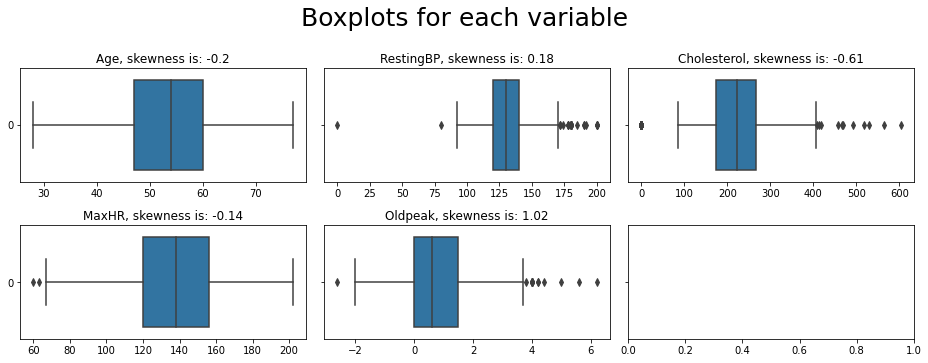

In [ ]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=raw_df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

<a id="3.3"></a>
## 3.3 Inter Quartile Range (IQR)

Tukey’s (1977) technique is used to detect outliers in skewed or non bell-shaped data since it makes no distributional assumptions. However, Tukey’s method may not be appropriate for a small sample size. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:

1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

For oulier detection methods look here: https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

In [ ]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]

    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

<a id="3.4"></a>
## 3.4 Dropping outliers

In [ ]:
# detecting outliers
Outliers_IQR = IQR_method(raw_df,1,numerical_columns)

# dropping outliers
df = raw_df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 16


<a id="3.5"></a>
## 3.5 Creating dummies

In [ ]:
df = pd.get_dummies(df, drop_first=True)

<a id="3.6"></a>
## 3.6 Train test split

In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

<a id="3.7"></a>
## 3.7 Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [ ]:
col_names = numerical_columns
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

<a id="4"></a>
# 4. Model selection

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
estimator = []
estimator.append(('Neural Network', MLPClassifier(max_iter = 10000) ))
estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier() ))
estimator.append(('RandomForest', RandomForestClassifier() ))
#estimator.append(('KNN', KNeighborsClassifier() ))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('AdaBoostClassifier', AdaBoostClassifier() ))
estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier() ))
estimator.append(('XGB', XGBClassifier() ))
estimator.append(('CatBoost', CatBoostClassifier(logging_level='Silent') ))

<a id="5"></a>
# 5. Voting Classifier with hard voting

In [ ]:
VC_hard = VotingClassifier(estimators = estimator, voting ='hard')
VC_hard.fit(X_train, y_train)
y_pred = VC_hard.predict(X_test)

<a id="5.1"></a>
## 5.1 Classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       122
           1       0.90      0.92      0.91       150

    accuracy                           0.90       272
   macro avg       0.90      0.89      0.90       272
weighted avg       0.90      0.90      0.90       272



<a id="5.2"></a>
## 5.2 Confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)

VC_hard_Recall = recall_score(y_test, y_pred)
VC_hard_Precision = precision_score(y_test, y_pred)
VC_hard_f1 = f1_score(y_test, y_pred)
VC_hard_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[106  16]
 [ 12 138]]


<a id="5.3"></a>
## 5.3 K-Fold Cross-validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.

The purpose of cross–validation is to test the ability of a machine learning model to predict new data.

In [ ]:
from statistics import stdev
score = cross_val_score(VC_hard, X_train, y_train, cv=5, scoring='recall')
VC_hard_cv_score = score.mean()
VC_hard_cv_stdev = stdev(score)
print('Cross Validation Recall scores are: {}'.format(score))
print('Average Cross Validation Recall score: ', VC_hard_cv_score)
print('Cross Validation Recall standard deviation: ', VC_hard_cv_stdev)

Cross Validation Recall scores are: [0.92857143 0.84285714 0.85714286 0.92753623 0.89855072]
Average Cross Validation Recall score:  0.8909316770186336
Cross Validation Recall standard deviation:  0.039583896359237175


In [ ]:
ndf = [(VC_hard_Recall, VC_hard_Precision, VC_hard_f1, VC_hard_accuracy, VC_hard_cv_score, VC_hard_cv_stdev)]

VC_hard_score = pd.DataFrame(data = ndf, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
VC_hard_score.insert(0, 'Voting Classifier', 'Hard Voting')
VC_hard_score

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Hard Voting,0.92,0.896104,0.907895,0.897059,0.890932,0.039584


<a id="6"></a>
# 6. Voting Classifier with soft voting

In [ ]:
VC_soft = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft.fit(X_train, y_train)
y_pred = VC_soft.predict(X_test)

<a id="6.1"></a>
## Classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       122
           1       0.91      0.92      0.92       150

    accuracy                           0.91       272
   macro avg       0.91      0.91      0.91       272
weighted avg       0.91      0.91      0.91       272



<a id="6.2"></a>
## 6.2 Confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)

VC_soft_Recall = recall_score(y_test, y_pred)
VC_soft_Precision = precision_score(y_test, y_pred)
VC_soft_f1 = f1_score(y_test, y_pred)
VC_soft_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[109  13]
 [ 12 138]]


<a id="6.3"></a>
## 6.3 K-Fold Cross-validation

In [ ]:
score2 = cross_val_score(VC_soft, X_train, y_train, cv=5, scoring='recall')

In [ ]:
VC_soft_cv_score = score2.mean()
VC_soft_cv_stdev = stdev(score2)

print('Cross Validation Recall scores are: {}'.format(score2))
print('Average Cross Validation Recall score: ', VC_soft_cv_score)
print('Cross Validation Recall standard deviation: ', VC_soft_cv_stdev)

Cross Validation Recall scores are: [0.91428571 0.84285714 0.82857143 0.89855072 0.89855072]
Average Cross Validation Recall score:  0.8765631469979297
Cross Validation Recall standard deviation:  0.0381745955328178


In [ ]:
ndf2 = [(VC_soft_Recall, VC_soft_Precision, VC_soft_f1, VC_soft_accuracy, VC_soft_cv_score, VC_soft_cv_stdev)]

VC_soft_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
VC_soft_score.insert(0, 'Voting Classifier', 'Soft Voting')
VC_soft_score

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Soft Voting,0.92,0.913907,0.916944,0.908088,0.876563,0.038175


<a id="7"></a>
## 7. Result comparison

In [ ]:
predictions = pd.concat([VC_hard_score, VC_soft_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Avg CV Recall'], ascending=False)

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Hard Voting,0.92,0.896104,0.907895,0.897059,0.890932,0.039584
1,Soft Voting,0.92,0.913907,0.916944,0.908088,0.876563,0.038175


<a id="8"></a>
# 8. AUC-ROC Curve for Voting Classifier with soft voting

#### I present AUC-ROC Curve for Voting Classifier with soft voting, because predict_proba is not available when voting='hard'

In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Voting Classifier with soft voting: {ROCAUCscore:.4f}")

AUC-ROC Curve for Voting Classifier with soft voting: 0.9067


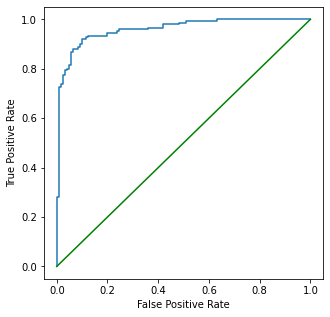

In [ ]:
y_proba = VC_soft.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

<a id="9"></a>
## 9. Precision-Recall Curve (PR curve) for Voting Classifier with soft voting

The precision-recall curve shows the tradeoff between precision and recalls for different thresholds.

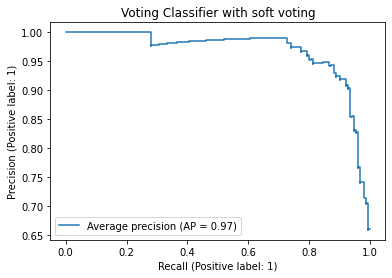

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    VC_soft, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Voting Classifier with soft voting")

We can clearly see that we need to trade a lot of Precision to achieve better Recall.

<a id="10"></a>
# 10. My other notebooks

GridSearchCV + KFold CV: The Right Way

https://www.kaggle.com/code/marcinrutecki/gridsearchcv-kfold-cv-the-right-way

How to create a meaningful EDA

https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda

SMOTE and Tomek Links for imbalanced data

https://www.kaggle.com/code/marcinrutecki/smote-and-tomek-links-for-imbalanced-data

Best techniques and metrics for Imbalanced Dataset

https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

Regression Models Evaluation Metrics

https://www.kaggle.com/code/marcinrutecki/regression-models-evaluation-metrics

Clustering methods - comprehensive study

https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study

Outlier detection methods!

https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

Multicollinearity - detection and remedies

https://www.kaggle.com/code/marcinrutecki/multicollinearity-detection-and-remedies

<a id="11"></a>
# 11. References

https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/

http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/

https://medium.com/analytics-vidhya/voting-classifier-in-machine-learning-9534504eba39

https://towardsdatascience.com/combine-your-machine-learning-models-with-voting-fa1b42790d84